# 基于卷积神经网络的手写英文字母识别系统研究

## 准备数据集及数据预处理

### 将下载的数据集按类重命名

In [1]:

# import os
# import string
#
# # 定义源目录路径
# source_dir = "EnglishHnd/EnglishHnd/English/Hnd/Img"
#
# # 生成目标文件夹名称列表
# target_folders = list(string.digits) + list(string.ascii_uppercase) + [f"{char}_" for char in string.ascii_lowercase]
#
# # 获取源目录下的所有文件夹名称
# source_folders = sorted([f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))])
#
# # 确保源文件夹数量与目标文件夹数量一致
# if len(source_folders) != len(target_folders):
#     raise ValueError("源文件夹数量与目标文件夹数量不一致")
#
# # 重命名文件夹
# for source_folder, target_folder in zip(source_folders, target_folders):
#     source_path = os.path.join(source_dir, source_folder)
#     target_path = os.path.join(source_dir, target_folder)
#
#     try:
#         os.rename(source_path, target_path)
#         print(f"重命名: {source_path} -> {target_path}")
#     except FileExistsError:
#         print(f"目标文件夹 {target_path} 已存在，跳过重命名 {source_path}")
#     except Exception as e:
#         print(f"重命名 {source_path} 到 {target_path} 时出错: {e}")




### 划分训练集和测试集

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
#数据增强
from albumentations.pytorch import ToTensorV2
import albumentations as A
from myCnn.baseline.LeNet5 import LeNet5
from myCnn.train_model import train_model
from myCnn.utils import split_dataset
from myCnn.baseline.resnet18 import resnet18
from myCnn.baseline.mobilenet_v2 import mobilenet_v2
from myCnn.baseline.svm_model import train_svm, flatten_images
from myCnn.CBAMNet_Lite import CharsLightAttentionNet
from myCnn.evaluate_model import evaluate_model
EPOCH = 100
BATCH_SIZE = 128
LR = 1e-4

In [3]:
# # 定义数据预处理变换
# transform = T.Compose([
#     T.Resize((64, 64)),
#     T.Grayscale(num_output_channels=3),
#     T.RandomRotation(15),  # 数据增强：随机旋转
#     T.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 位移
#     T.ToTensor(),
#     # 如果需要标准化，可以取消注释以下行
#     T.Normalize([0.5], [0.5])
# ])
class AlbumentationsTransform:
    def __init__(self):
        self.transform=A.Compose([
            A.Resize(32, 32),
            A.Rotate(limit=15, p=0.5),
            A.Affine(translate_percent=(0.1,0.1),p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=(0.5,),std=(0.5,)),
            ToTensorV2()
        ])
    def __call__(self, img):
        img=np.array(img)
        # img = np.array(img.convert('L'))
        return self.transform(image=img)['image']

transform=AlbumentationsTransform()


训练集大小: 2387
验证集大小: 511
测试集大小: 512
{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, 'a_': 36, 'b_': 37, 'c_': 38, 'd_': 39, 'e_': 40, 'f_': 41, 'g_': 42, 'h_': 43, 'i_': 44, 'j_': 45, 'k_': 46, 'l_': 47, 'm_': 48, 'n_': 49, 'o_': 50, 'p_': 51, 'q_': 52, 'r_': 53, 's_': 54, 't_': 55, 'u_': 56, 'v_': 57, 'w_': 58, 'x_': 59, 'y_': 60, 'z_': 61}


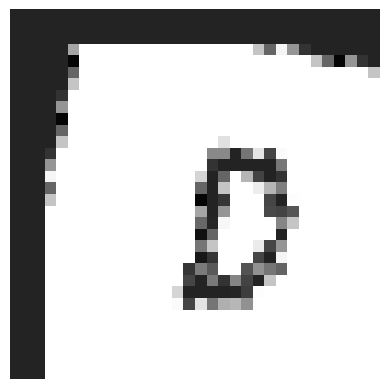

In [4]:
# 使用函数划分数据集
train_loader, val_loader, test_loader, full_dataset = split_dataset(
    root_dir="EnglishHnd/EnglishHnd/English/Hnd/Img",
    # root_dir="EnglishImg/EnglishImg/English/Img/GoodImg/Bmp",
    transform=transform,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    batch_size=BATCH_SIZE,
    shuffle=True,
    random_seed=42
)

# 打印数据集大小
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"验证集大小: {len(val_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")

# 获取类别数量
label_num = len(full_dataset.class_to_idx)
print(full_dataset.class_to_idx)
# 数据可视化
to_img = T.ToPILImage()
a = to_img(train_loader.dataset[0][0])  # size=[1, 28, 28]
plt.imshow(a)
plt.axis('off')
plt.show()


# 获取类别数量
label_num = len(full_dataset.class_to_idx)

In [5]:

# # 获取展平后的训练集和验证集
# X_train, y_train = flatten_images(train_loader)
# X_val, y_val = flatten_images(val_loader)

In [6]:

# # 训练SVM模型
# svm_clf, train_acc, val_acc = train_svm(X_train, y_train, X_val, y_val)

In [7]:

# 初始化模型
cnn = mobilenet_v2(pretrained=True)
# 加载最好的权重模型
# cnn.load_state_dict(torch.load('myCnn/baseline_weight/resnet18_best_model.pth'))

print(cnn)

# 检查 CUDA 是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn.to(device)  # 将模型迁移到 GPU

# 假设使用cpu
# cnn.to('cpu')

# 创建优化器
optimizer = torch.optim.AdamW(cnn.parameters(), lr=3e-4, weight_decay=0.05)

# 创建学习率调度器（Cosine退火）
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCH,  # 周期长度
    eta_min=1e-5       # 最小学习率
)

# 定义损失函数
loss_func = nn.CrossEntropyLoss()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

D:\app\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\app\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# 训练模型
cnn = train_model(cnn, train_loader, val_loader, loss_func, optimizer, num_epochs=EPOCH)



2025-04-18 18:58:57,659 - INFO - Using device: cuda
2025-04-18 18:58:57,664 - INFO - Starting training...


KeyboardInterrupt: 

In [22]:
# 推理

top1_acc, top3_acc, inference_speed = evaluate_model(cnn, test_loader, device)
print(f"Top-1 Accuracy: {top1_acc:.4f}")
print(f"Top-3 Accuracy: {top3_acc:.4f}")
print(f"Inference Speed: {inference_speed * 1000:.4f} ms per sample")

Top-1 Accuracy: 72.2656
Top-3 Accuracy: 92.1875
Inference Speed: 0.0234 ms per sample
